In [4]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import pickle
import networkx as nx
import numpy as np
import os

seeds = [6, 7, 10, 11, 19, 22, 31, 42, 666, 888]
splitFilePrefix = '_x86_64_withVal_withPretrain_ghidra_'


## Simple Graph2Vec Experiments

### Functions

In [6]:
class WLGraph2Vec:
    def __init__(self, num_iterations=3):
        """
        初始化 WL Graph2Vec
        
        參數:
            num_iterations: WL迭代次數
        """
        self.num_iterations = num_iterations
        
    def _wl_iteration(self, G, node_features):
        """執行一次WL迭代"""
        new_features = {}
        
        for node in G.nodes():
            # 獲取節點當前特徵
            current_feature = node_features[node]
            
            # 收集所有鄰居的特徵
            neighbor_features = []
            for neighbor in G.neighbors(node):
                neighbor_features.append(node_features[neighbor])
            
            if neighbor_features:
                # 計算鄰居特徵的平均值
                neighbor_mean = np.mean(neighbor_features, axis=0)
                # 組合當前節點特徵和鄰居特徵
                new_feature = 0.5 * current_feature + 0.5 * neighbor_mean
            else:
                new_feature = current_feature
                
            new_features[node] = new_feature
            
        return new_features

    def transform(self, G):
        """
        使用WL機制將圖轉換為128維向量
        
        參數:
            G: networkx圖物件，節點的'x'屬性包含tensor特徵
        返回:
            numpy.ndarray: 128維向量
        """
        # 初始化節點特徵
        node_features = {}
        for node in G.nodes():
            if isinstance(G.nodes[node]['x'], torch.Tensor):
                node_features[node] = G.nodes[node]['x'].numpy()
            else:
                node_features[node] = np.array(G.nodes[node]['x'])
        
        # 儲存每次迭代的圖級別特徵
        graph_features = []
        
        # WL迭代
        for _ in range(self.num_iterations):
            # 更新節點特徵
            node_features = self._wl_iteration(G, node_features)
            
            # 計算當前迭代的圖級別特徵
            current_features = np.array(list(node_features.values()))
            graph_features.append(np.mean(current_features, axis=0))
            graph_features.append(np.max(current_features, axis=0))
            graph_features.append(np.min(current_features, axis=0))
        
        # 組合所有特徵
        combined_features = np.concatenate(graph_features)
        
        # 如果特徵維度不是128，則需要調整
        if len(combined_features) > 128:
            # 使用平均池化減少維度
            splits = np.array_split(combined_features, 128)
            final_vector = np.array([np.mean(split) for split in splits])
        elif len(combined_features) < 128:
            # 使用線性插值增加維度
            original_positions = np.linspace(0, 1, len(combined_features))
            new_positions = np.linspace(0, 1, 128)
            final_vector = np.interp(new_positions, original_positions, combined_features)
        else:
            final_vector = combined_features
            
        # 標準化最終向量
        if np.std(final_vector) != 0:
            final_vector = (final_vector - np.mean(final_vector)) / np.std(final_vector)
        else:
            final_vector = final_vector - np.mean(final_vector)

        return final_vector

In [7]:
from torch_geometric.utils.convert import from_networkx
def load_split_data(seed):
    """
    載入訓練集、驗證集和測試集
    
    參數:
        seed: 隨機種子
    返回:
        tuple: (訓練集, 驗證集, 測試集)
    """
    path = "/home/manying/Projects/fcgFewShot/dataset/split"

    train_file = os.path.join(path, 'train'+ splitFilePrefix + str(seed) + '.txt')
    val_file = os.path.join(path, 'val'+ splitFilePrefix + str(seed) + '.txt')
    test_file = os.path.join(path, 'test'+ splitFilePrefix + str(seed) + '.txt')
    

    train_data = []
    with open(train_file, 'r') as f:
        for line in f:
            train_data.append(line.strip())
    
    val_data = []

    with open(val_file, 'r') as f:
        for line in f:
            val_data.append(line.strip())
    
    test_data = []
    with open(test_file, 'r') as f:
        for line in f:
            test_data.append(line.strip())
        
    return train_data, val_data, test_data 

def load_dataset(familyList, seed):
    """
    載入圖數據集
    
    參數:
        familyList: list of str, 指定要載入的家族名稱
    返回:
        list of networkx.Graph: 圖數據集
    """
    path = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/Advanced Micro Devices X86-64"
    graphs = []
    labels = []
    paths = []
    for family in familyList:
        graph_folder = os.path.join(path, family)
        for graph_file in os.listdir(graph_folder):
            if graph_file.endswith('.gpickle'):
                graph = load_graph(os.path.join(graph_folder, graph_file))
                graphs.append(graph)
                labels.append(family)
                paths.append(os.path.join(graph_folder, graph_file))
    return graphs, labels, paths

def load_graph(path):
    with open(path, "rb") as f:
        fcg = pickle.load(f)
        for node in fcg.nodes:
            if len(fcg.nodes[node]["x"]) == 0:
                fcg.nodes[node]["x"] = torch.zeros(128, dtype=torch.float32)
            if not isinstance(fcg.nodes[node]["x"], torch.Tensor):
                fcg.nodes[node]["x"] = torch.tensor(fcg.nodes[node]["x"], dtype=torch.float32)
    return fcg


In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
import random

def evaluate_few_shot(test_vectors, test_labels, n_episodes=100, mode="Nn"):
    """
    評估few-shot learning的平均準確率
    
    參數:
        test_vectors: 測試數據向量
        test_labels: 測試數據標籤
        n_episodes: 評估回合數
    """
    # 整理每個類別的樣本索引
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(test_labels):
        label_to_indices[label].append(idx)
    
    def run_episode(n_way, n_shot):
        # 計算query樣本數量：共20個樣本減去support set的數量
        n_query = 20 - n_shot
        
        # 隨機選擇n_way個類別
        selected_classes = random.sample(list(label_to_indices.keys()), n_way)
        support_X = []
        support_y = []
        query_X = []
        query_y = []
        
        # 對每個選中的類別採樣數據
        for cls in selected_classes:
            cls_indices = label_to_indices[cls]
            selected_indices = random.sample(cls_indices, n_shot + n_query)
            
            # 分割support set和query set
            support_indices = selected_indices[:n_shot]
            query_indices = selected_indices[n_shot:]
            
            # 收集數據
            support_X.extend([test_vectors[idx] for idx in support_indices])
            support_y.extend([cls] * n_shot)
            query_X.extend([test_vectors[idx] for idx in query_indices])
            query_y.extend([cls] * n_query)
        
        # 轉換為numpy數組
        support_X = np.array(support_X)
        support_y = np.array(support_y)
        query_X = np.array(query_X)
        query_y = np.array(query_y)

        if mode == "Proto":
            # 計算每個類別的原型向量
            prototypes = []
            for cls in selected_classes:
                cls_indices = np.where(support_y == cls)[0]
                cls_vectors = support_X[cls_indices]
                prototype = np.mean(cls_vectors, axis=0)
                prototypes.append(prototype)
            prototypes = np.array(prototypes)

            # 計算每個query樣本到原型向量的歐幾里得距離
            distances = np.linalg.norm(query_X[:, None] - prototypes, axis=2)
            predictions = np.argmin(distances, axis=1)
            predictions = np.array([selected_classes[pred] for pred in predictions])
            
        elif mode == "Nn":
            # 訓練和預測
            classifier = KNeighborsClassifier(n_neighbors=1)
            classifier.fit(support_X, support_y)
            predictions = classifier.predict(query_X)
        
        # 計算準確率
        accuracy = np.mean(predictions == query_y)
        confusion_matrix = np.zeros((10, 10))

        if mode == "Proto" and n_way == 10 and n_shot == 5:
            ## generate confusion matrix in 10-way 5-shot
            for i in range(len(predictions)):
                confusion_matrix[query_y[i]][predictions[i]] += 1
            confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]

        return accuracy, confusion_matrix
    
    # 評估所有配置
    configs = [(5, 5), (10, 5), (5, 10), (10, 10)]
    results = {}
    
    for n_way, n_shot in configs:
        # 運行n_episodes次並計算平均準確率
        if mode == "Proto":
            accuracies = []
            confusion_matrix = np.zeros((10, 10))
            for _ in range(n_episodes):
                accuracy, confusion_matrix = run_episode(n_way, n_shot)
                accuracies.append(accuracy)
                confusion_matrix += confusion_matrix
            results[f"{n_way}-way {n_shot}-shot"] = np.mean(accuracies), confusion_matrix / n_episodes
        elif mode == "Nn":
            accuracies = [run_episode(n_way, n_shot)[0] for _ in range(n_episodes)]
            results[f"{n_way}-way {n_shot}-shot"] = np.mean(accuracies)
        
    return results

### Generate Dataset

In [9]:
## Gen data

dataset = {}

for seed in seeds:
    train_data, val_data, test_data = load_split_data(seed)
    print('seed:', seed)

    test_graphs, test_labels, test_paths = load_dataset(test_data, seed)
    print("Converting graphs to vectors...")

    graph2vec = WLGraph2Vec(num_iterations=3)
    # train_vectors = [graph2vec.transform(graph) for graph in train_graphs]
    test_vectors = [graph2vec.transform(graph) for graph in test_graphs]
    # train_vectors = np.array(train_vectors)
    test_vectors = np.array(test_vectors)

    dataset[seed] = (test_vectors, test_labels, test_paths)


seed: 6


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...
seed: 7
Converting graphs to vectors...
seed: 10
Converting graphs to vectors...
seed: 11
Converting graphs to vectors...
seed: 19
Converting graphs to vectors...
seed: 22
Converting graphs to vectors...
seed: 31
Converting graphs to vectors...
seed: 42
Converting graphs to vectors...
seed: 666
Converting graphs to vectors...
seed: 888
Converting graphs to vectors...


### Nn Experiements

In [10]:
final_results = {}

for seed in seeds:
    test_vectors = dataset[seed][0]
    test_labels = dataset[seed][1]
    test_paths = dataset[seed][2]

    print(f"Seed: {seed}")
    # label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(test_labels)
    test_labels = label_encoder.transform(test_labels)

    results = evaluate_few_shot(test_vectors, test_labels, n_episodes=1000, mode="Nn")

    for config, acc in results.items():
        print(f"{config}: {acc}")

    final_results[seed] = results


Seed: 6
5-way 5-shot: 0.7682133333333334
10-way 5-shot: 0.6999266666666666
5-way 10-shot: 0.8368800000000001
10-way 10-shot: 0.7638400000000001
Seed: 7
5-way 5-shot: 0.9198799999999999
10-way 5-shot: 0.8832133333333334
5-way 10-shot: 0.94086
10-way 10-shot: 0.9177099999999999
Seed: 10
5-way 5-shot: 0.89288
10-way 5-shot: 0.84708
5-way 10-shot: 0.9121400000000001
10-way 10-shot: 0.8795499999999999
Seed: 11
5-way 5-shot: 0.9643999999999998
10-way 5-shot: 0.9495399999999999
5-way 10-shot: 0.9784200000000001
10-way 10-shot: 0.97028
Seed: 19
5-way 5-shot: 0.8937466666666667
10-way 5-shot: 0.8666533333333334
5-way 10-shot: 0.9306000000000001
10-way 10-shot: 0.9065899999999999
Seed: 22
5-way 5-shot: 0.8543466666666666
10-way 5-shot: 0.8079400000000001
5-way 10-shot: 0.89176
10-way 10-shot: 0.8508
Seed: 31
5-way 5-shot: 0.8920266666666666
10-way 5-shot: 0.8348933333333334
5-way 10-shot: 0.89654
10-way 10-shot: 0.8434100000000001
Seed: 42
5-way 5-shot: 0.8649466666666666
10-way 5-shot: 0.8094
5

In [11]:
# calculate average results
average_results = defaultdict(float)
for seed, results in final_results.items():
    for config, acc in results.items():
        average_results[config] += acc

for config, acc in average_results.items():
    average_results[config] = acc / len(seeds)

print("\nAverage results:")
for config, acc in average_results.items():
    print(f"{config}: {acc}")


Average results:
5-way 5-shot: 0.8787906666666666
10-way 5-shot: 0.8284546666666668
5-way 10-shot: 0.9100900000000001
10-way 10-shot: 0.866737


### Proto Experiments

In [12]:
## Proto mode

final_results = {}

for seed in seeds:

    test_vectors = dataset[seed][0]
    test_labels = dataset[seed][1]
    test_paths = dataset[seed][2]
    print('seed:', seed)
    # label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(test_labels)
    test_labels = label_encoder.transform(test_labels)

    results = evaluate_few_shot(test_vectors, test_labels, n_episodes=1000, mode="Proto")

    for config, result in results.items():
        print(f"{config}: {result[0]}")
        # if config == "10-way 5-shot":
        #     print(result[1])


    final_results[seed] = results

seed: 6


5-way 5-shot: 0.6821733333333333
10-way 5-shot: 0.5899533333333333
5-way 10-shot: 0.70338
10-way 10-shot: 0.6131899999999999
seed: 7
5-way 5-shot: 0.8536933333333333
10-way 5-shot: 0.8010066666666666
5-way 10-shot: 0.8678400000000001
10-way 10-shot: 0.80723
seed: 10
5-way 5-shot: 0.8451733333333333
10-way 5-shot: 0.7605999999999999
5-way 10-shot: 0.8528000000000001
10-way 10-shot: 0.76235
seed: 11
5-way 5-shot: 0.9332133333333333
10-way 5-shot: 0.9115866666666667
5-way 10-shot: 0.9308
10-way 10-shot: 0.91503
seed: 19
5-way 5-shot: 0.8322666666666666
10-way 5-shot: 0.7784266666666666
5-way 10-shot: 0.85102
10-way 10-shot: 0.80875
seed: 22
5-way 5-shot: 0.74608
10-way 5-shot: 0.6821333333333334
5-way 10-shot: 0.7609799999999999
10-way 10-shot: 0.6992299999999999
seed: 31
5-way 5-shot: 0.8121866666666667
10-way 5-shot: 0.7429866666666666
5-way 10-shot: 0.8040800000000001
10-way 10-shot: 0.7499600000000001
seed: 42
5-way 5-shot: 0.8226133333333333
10-way 5-shot: 0.7193066666666666
5-way 10

In [13]:
# calculate average results
average_results = defaultdict(float)
for seed, results in final_results.items():
    for config, result in results.items():
        average_results[config] += result[0]

for config, acc in average_results.items():
    average_results[config] = acc / len(seeds)

print("\nAverage results:")
for config, acc in average_results.items():
    print(f"{config}: {acc}")


Average results:
5-way 5-shot: 0.8095213333333332
10-way 5-shot: 0.7327953333333334
5-way 10-shot: 0.81745
10-way 10-shot: 0.745579


### Visualize TSNE

Seed: 6


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


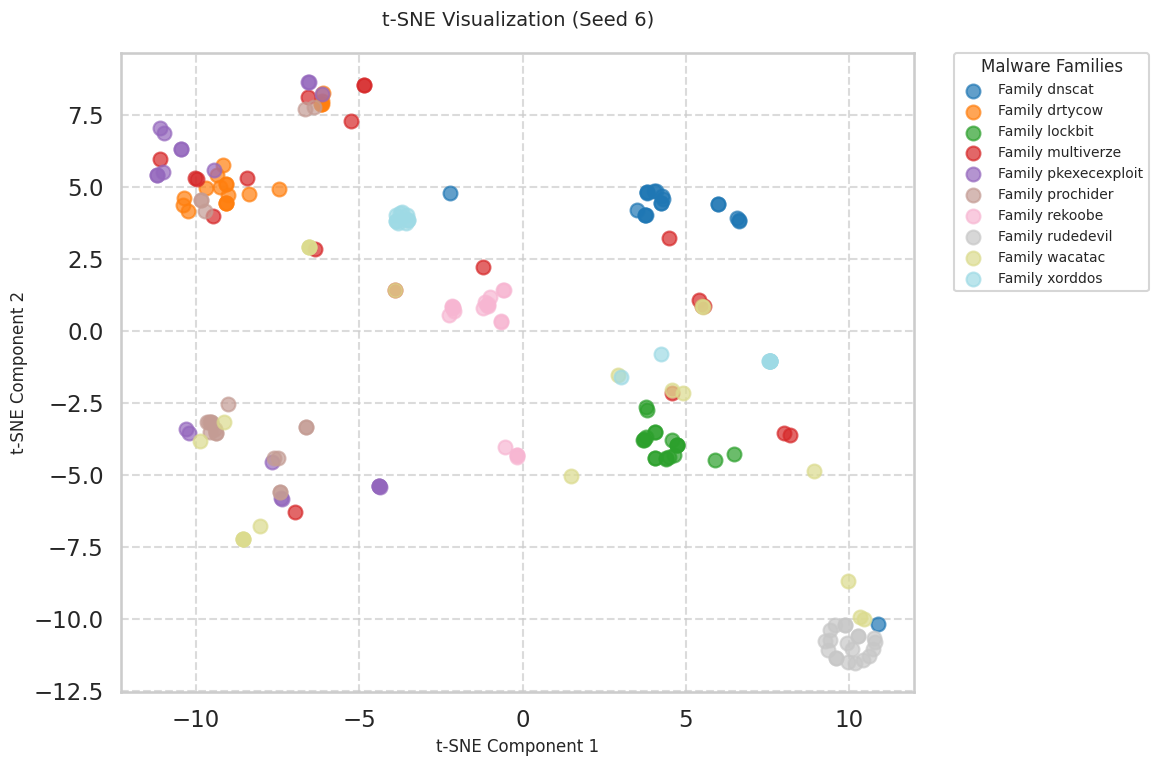

Seed: 7


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


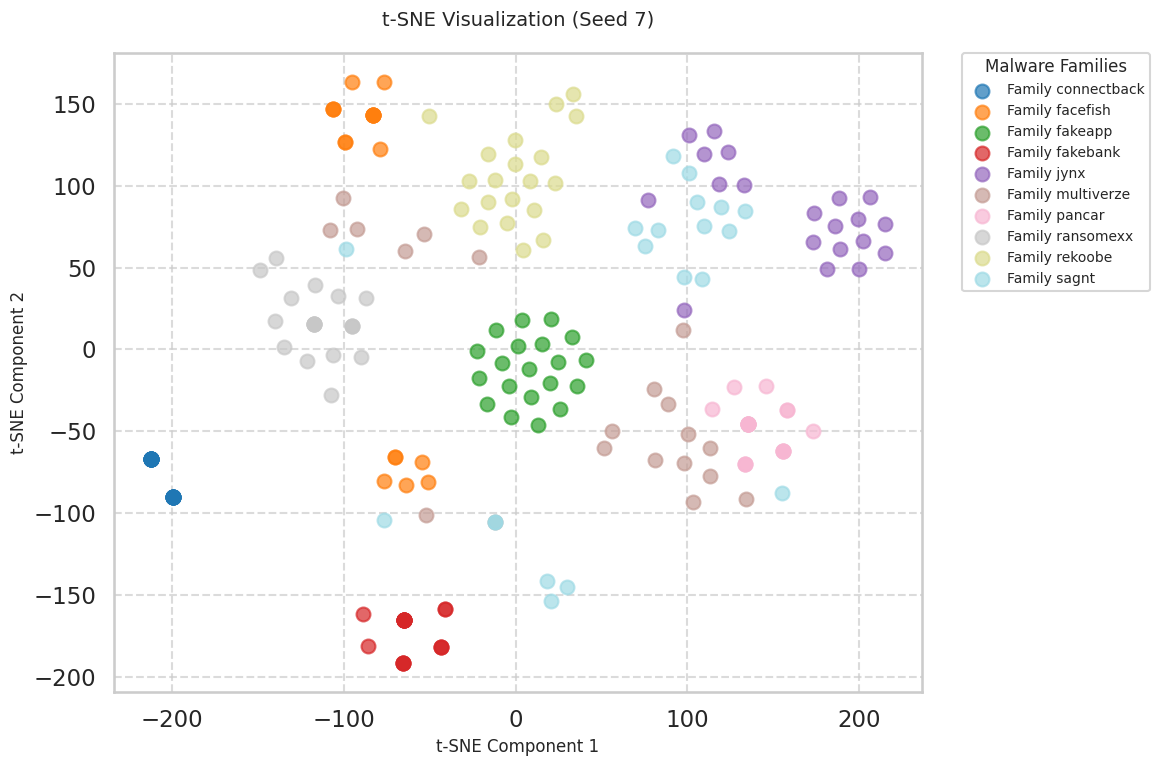

Seed: 10


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


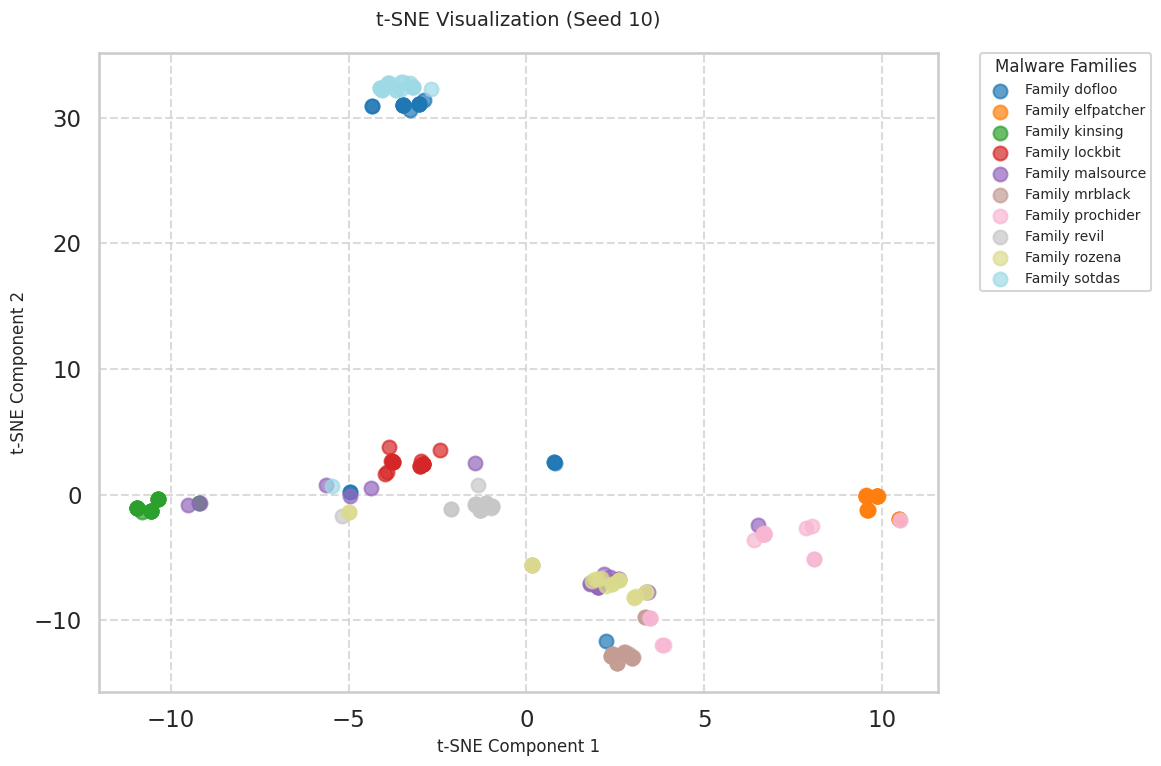

Seed: 11


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


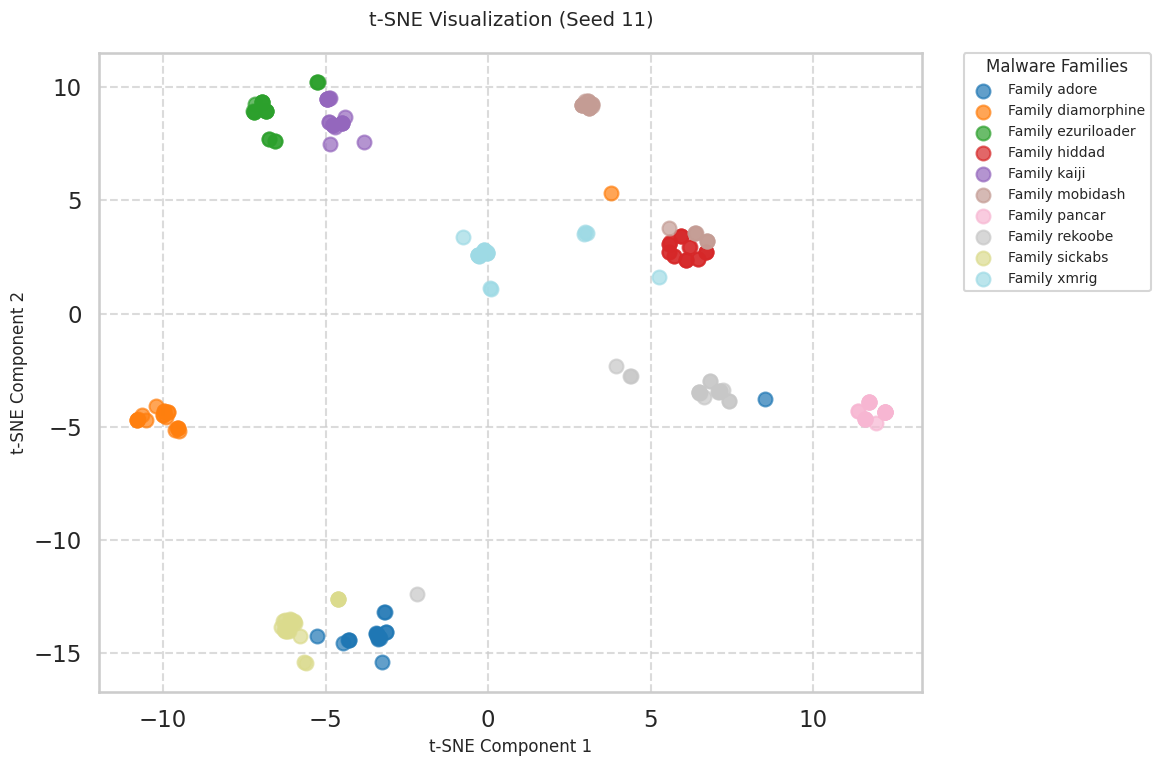

Seed: 19


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


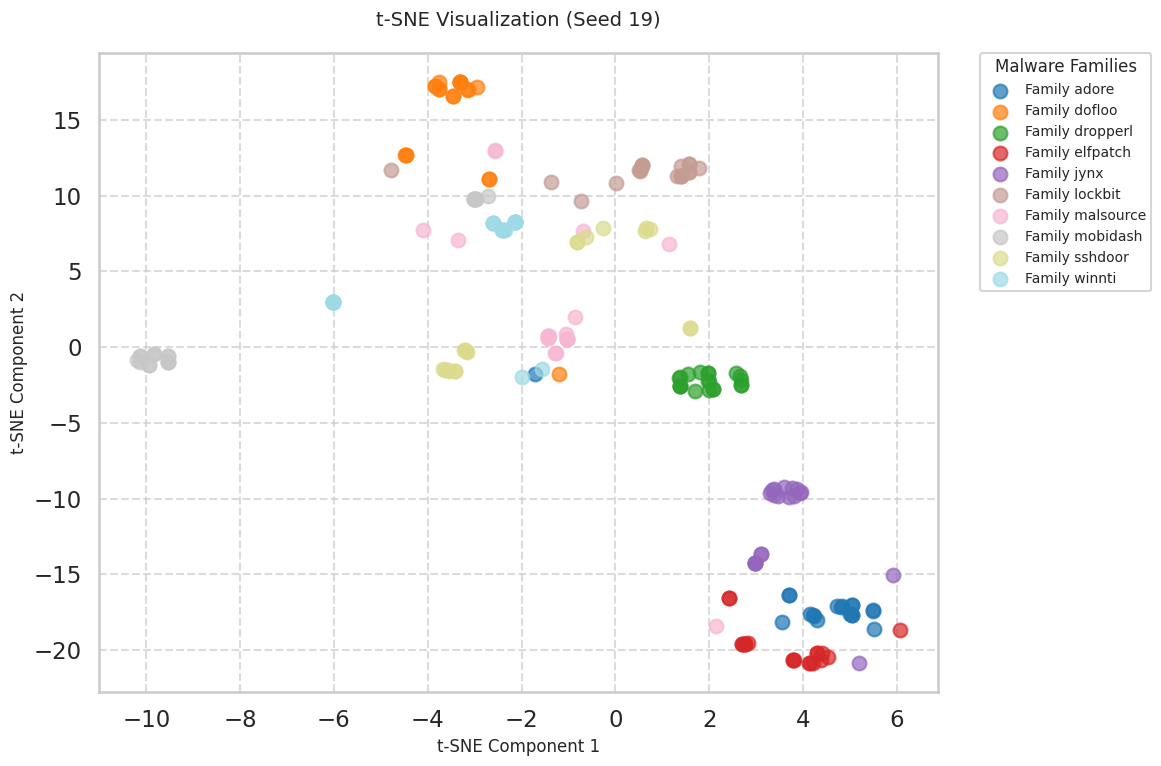

Seed: 22


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


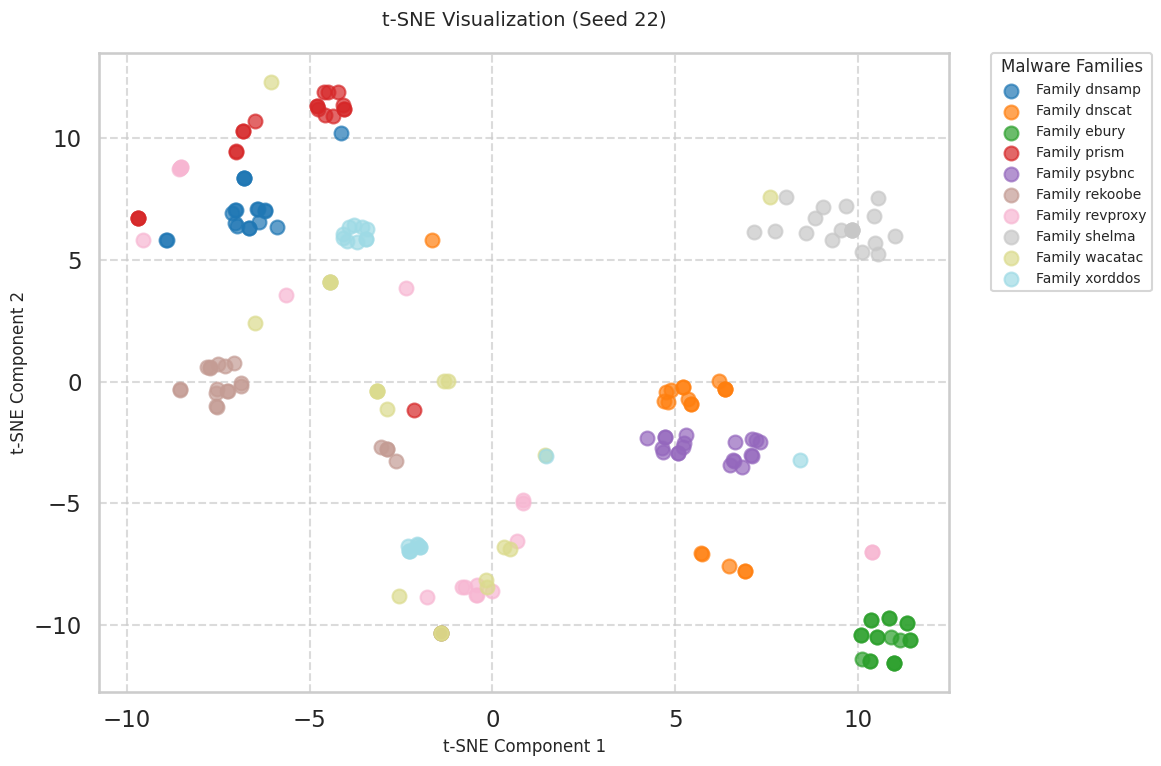

Seed: 31


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


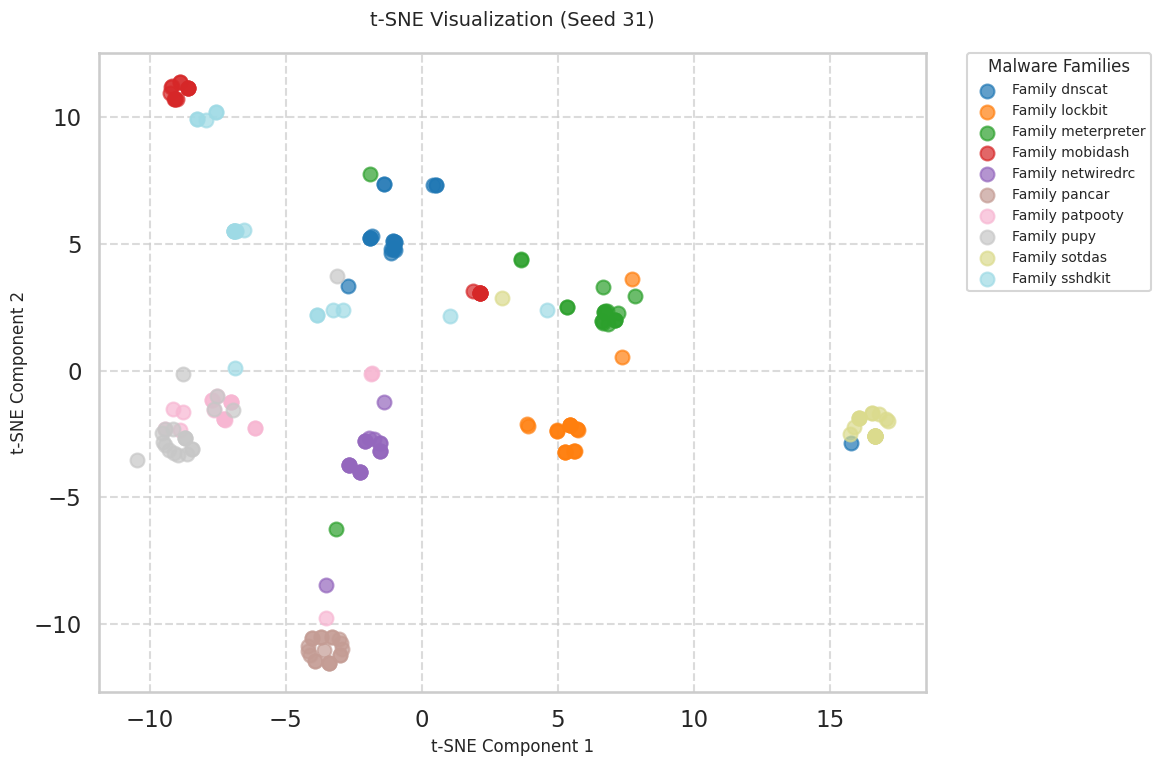

Seed: 42


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


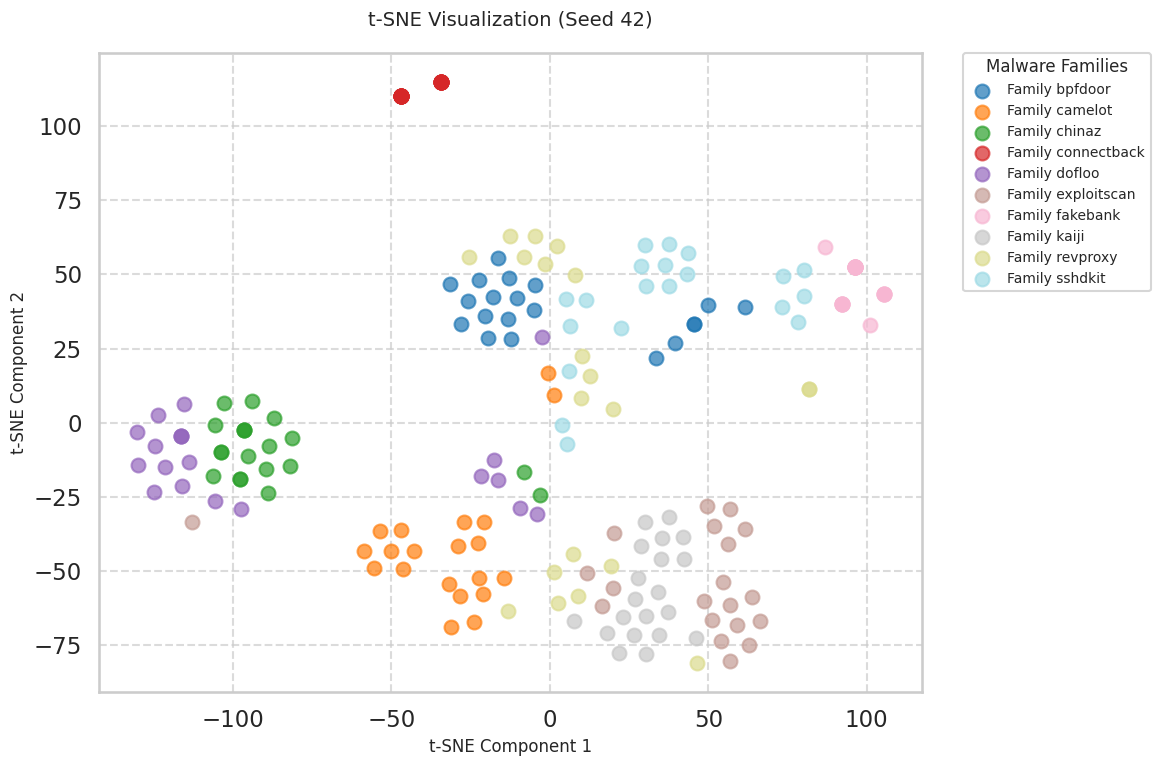

Seed: 666


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


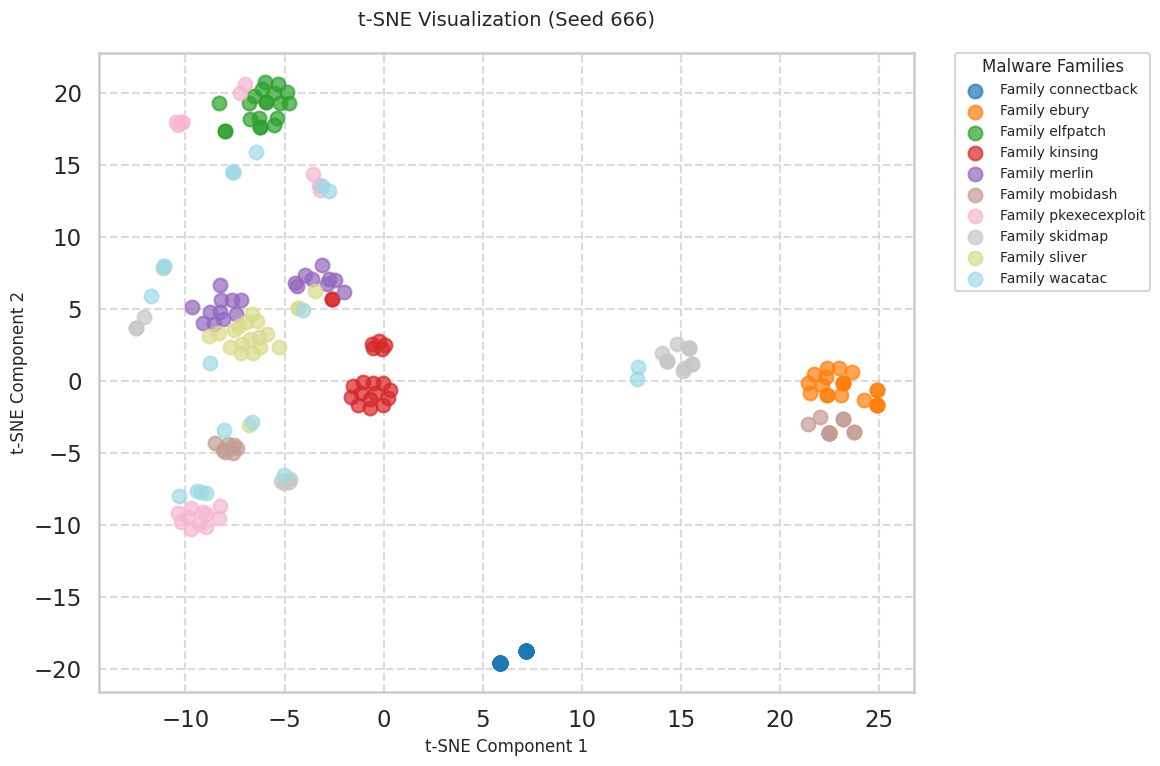

Seed: 888


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...


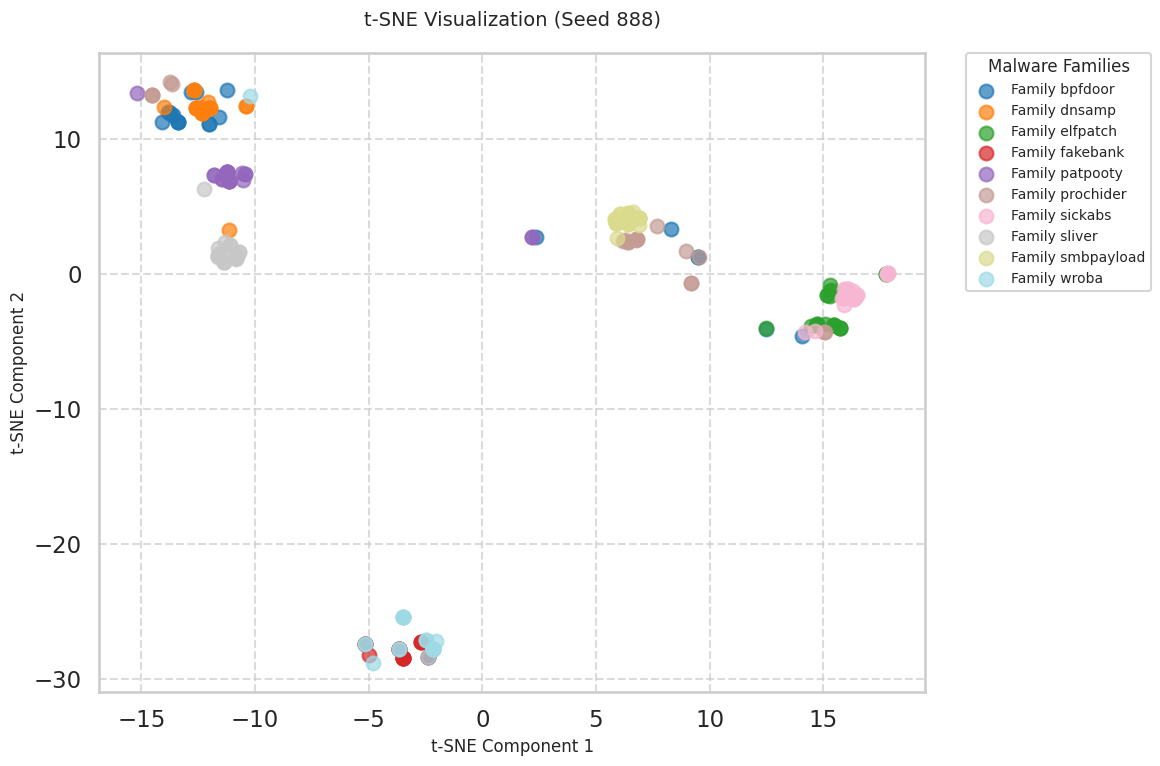

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_tsne(test_vectors, test_labels, seed):
    """
    使用t-SNE將高維向量視覺化
    
    參數:
        test_vectors: numpy array of shape (n_samples, n_features)
        test_labels: numpy array of shape (n_samples,)
        seed: 當前的隨機種子
    """
    # 確保數據是numpy數組
    test_vectors = np.array(test_vectors)
    test_labels = np.array(test_labels)
    
    # 標準化數據
    scaler = StandardScaler()
    test_vectors_scaled = scaler.fit_transform(test_vectors)
    
    # 應用t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        init='pca',  # 使用PCA初始化
        learning_rate='auto'  # 自動選擇學習率
    )
    
    # 轉換數據
    test_vectors_tsne = tsne.fit_transform(test_vectors_scaled)
    
    plt.figure(figsize=(12, 8))
    
    # 使用不同的配色方案
    n_classes = len(np.unique(test_labels))
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    

    plt.grid(True, linestyle='--', alpha=0.7)
    # 繪製散點圖
    for i, label in enumerate(np.unique(test_labels)):
        mask = test_labels == label
        plt.scatter(
            test_vectors_tsne[mask, 0],
            test_vectors_tsne[mask, 1],
            c='None',
            edgecolors=[colors[i]],
            label=f'Family {label}',
            alpha=1.0,
            s=100,
            linewidth=1.5
        )
    
    # 添加標題和標籤
    plt.title(f"t-SNE Visualization (Seed {seed})", fontsize=14, pad=20)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    
    # 調整圖例
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        title="Malware Families",
        title_fontsize=12,
        fontsize=10
    )
    
    # 調整布局
    plt.tight_layout()
    
    # 顯示圖形
    plt.show()
    
    # 關閉圖形以釋放內存
    plt.close()

# 使用示例
for seed in seeds:
    # 載入數據
    train_data, val_data, test_data = load_split_data(seed)
    print('Seed:', seed)
    
    # 準備測試數據
    test_graphs, test_labels, test_paths = load_dataset(test_data, seed)
    print("Converting graphs to vectors...")
    
    # 轉換圖為向量
    graph2vec = WLGraph2Vec(num_iterations=3)
    test_vectors = [graph2vec.transform(graph) for graph in test_graphs]
    test_vectors = np.array(test_vectors)
    
    # 檢查並處理NaN值
    if np.isnan(test_vectors).any():
        print("Warning: Found NaN values in vectors, replacing with 0")
        test_vectors = np.nan_to_num(test_vectors, nan=0.0)
    
    # 視覺化
    visualize_tsne(test_vectors, test_labels, seed)

## GraphSAGE model experiments

In [45]:
from utils import load_config
from loadDataset import LoadDataset
from trainModule import TestModule

In [47]:
for seed in seeds:
    dataset_folder = f"/home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_{seed}"
    for exp in os.listdir(dataset_folder):
        if os.path.isdir(os.path.join(dataset_folder, exp)):
            config = load_config(os.path.join(dataset_folder, exp, 'config.json'))
            config_path = os.path.join(dataset_folder, exp, 'config.json')
            config["paths"]["data"]["embedding_folder"] = "/home/manying/Projects/fcgFewShot/embeddings"
            print(f"Seed: {seed}, Experiment: {exp}")
            print(f"Config: {config_path}")
            dataset = LoadDataset(config)
            test_module = TestModule(config_path, dataset, config)
            test_module.temp_eval()
            print("\n")
    break

Seed: 6, Experiment: 5way_5shot_NnNet_with_pretrain_20250104_010925
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_5shot_NnNet_with_pretrain_20250104_010925/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Testing accuracy: 0.8124
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.8562
Finish evaluation


Seed: 6, Experiment: 5way_10shot_NnNet_with_pretrain_20250104_113856
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_10shot_NnNet_with_pretrain_20250104_113856/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


Testing accuracy: 0.8383
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.9041
Finish evaluation


Seed: 6, Experiment: 10way_10shot_NnNet_without_pretrain_20250106_171935
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_10shot_NnNet_without_pretrain_20250106_171935/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the

Testing: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Testing accuracy: 0.7875
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.8907
Finish evaluation


Seed: 6, Experiment: 10way_10shot_NnNet_with_pretrain_20250106_153519
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_10shot_NnNet_with_pretrain_20250106_153519/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Testing accuracy: 0.7936
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.8804
Finish evaluation


Seed: 6, Experiment: 5way_5shot_ProtoNet_with_pretrain_20250103_174933
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_5shot_ProtoNet_with_pretrain_20250103_174933/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Testing accuracy: 0.6591
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.6358
Finish evaluation


Seed: 6, Experiment: 5way_10shot_ProtoNet_with_pretrain_20250104_030057
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_10shot_ProtoNet_with_pretrain_20250104_030057/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Testing accuracy: 0.6673
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.6004
Finish evaluation


Seed: 6, Experiment: 10way_5shot_NnNet_without_pretrain_20250105_143425
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_5shot_NnNet_without_pretrain_20250105_143425/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the b

Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Testing accuracy: 0.7432
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.8079
Finish evaluation


Seed: 6, Experiment: 10way_5shot_NnNet_with_pretrain_20250105_115117
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_5shot_NnNet_with_pretrain_20250105_115117/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Testing accuracy: 0.7546
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.8213
Finish evaluation


Seed: 6, Experiment: 5way_10shot_NnNet_without_pretrain_20250104_121300
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_10shot_NnNet_without_pretrain_20250104_121300/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the b

Testing: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Testing accuracy: 0.8313
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.9050
Finish evaluation


Seed: 6, Experiment: 10way_5shot_ProtoNet_with_pretrain_20250104_124204
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_5shot_ProtoNet_with_pretrain_20250104_124204/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Testing accuracy: 0.5406
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.5492
Finish evaluation


Seed: 6, Experiment: 10way_10shot_ProtoNet_without_pretrain_20250106_035248
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_10shot_ProtoNet_without_pretrain_20250106_035248/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Usi

Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Testing accuracy: 0.5923
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.5152
Finish evaluation


Seed: 6, Experiment: 5way_5shot_ProtoNet_without_pretrain_20250104_003419
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_5shot_ProtoNet_without_pretrain_20250104_003419/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using t

Testing: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Testing accuracy: 0.6667
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.6303
Finish evaluation


Seed: 6, Experiment: 10way_10shot_ProtoNet_with_pretrain_20250105_152327
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_10shot_ProtoNet_with_pretrain_20250105_152327/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...


/home/manying/Projects/fcgFewShot/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Ablation evaluation... (testing dataset)")


Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Testing accuracy: 0.5516
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.5169
Finish evaluation


Seed: 6, Experiment: 5way_10shot_ProtoNet_without_pretrain_20250104_053453
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_10shot_ProtoNet_without_pretrain_20250104_053453/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using

Testing: 100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


Testing accuracy: 0.6949
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.17it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.6298
Finish evaluation


Seed: 6, Experiment: 10way_5shot_ProtoNet_without_pretrain_20250105_001310
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/10way_5shot_ProtoNet_without_pretrain_20250105_001310/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using

Testing: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Testing accuracy: 0.5588
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]
/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

Testing accuracy: 0.5352
Finish evaluation


Seed: 6, Experiment: 5way_5shot_NnNet_without_pretrain_20250104_014312
Config: /home/manying/Projects/fcgFewShot/checkpoints/x86_64_withVal_withPretrain_ghidra_6/5way_5shot_NnNet_without_pretrain_20250104_014312/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec...
Loading validation data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/valData.pkl...
Loading testing data...
Loading data from /home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_6/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided. Using the bes

Testing: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Testing accuracy: 0.7907
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]

Testing accuracy: 0.8438
Finish evaluation


